In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

from transformers import pipeline

2024-10-16 00:15:10.145375: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-16 00:15:12.835355: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-16 00:15:12.835693: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-16 00:15:13.183695: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-16 00:15:14.095548: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-16 00:15:14.098226: I tensorflow/core/platform/cpu_feature_guard.cc:1

## Table of Contents
* [Project objectives](#section_1_1)
* [Source data](#section_2_1)
* [Vaders model](#section_3_1)
* [RoBERTa base model](#section_4_1)
* [VADER vs RoBERTa Comparison](#section_5_1)
* [RoBERTa latest model](#section_6_1)
* [RoBERTa latest and base comparison](#section_7_1)

### Project objectives: <a class="anchor" id="section_1_1"></a>
* Find appropriate data to prepare sentiment analysis
* Use at least two model
* Select the best performing model

### Finding source for tests <a class="anchor" id="section_2_1"></a>

In [9]:
#Read the source
#Source - https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews
df = pd.read_csv('Reviews.csv')

In [4]:
#Load 500 line
df = df.head(500)

In [5]:
#Check shape
df.shape

(500, 10)

In [6]:
#Check head
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [7]:
#Clean up
df = df.drop(['ProductId', 'UserId', 'ProfileName', 
         'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time', 'Summary'], axis=1)

### Quick EDA

In [8]:
#Score counts
df['Score'].value_counts()

5    339
4     70
3     37
1     36
2     18
Name: Score, dtype: int64

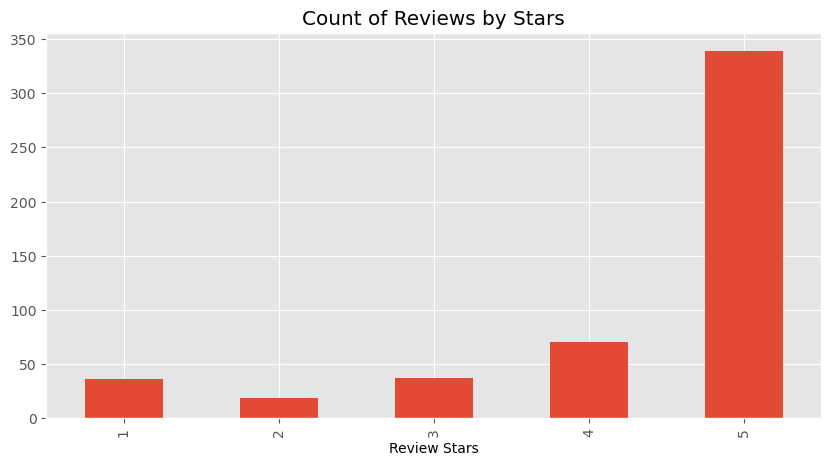

In [163]:
#Counts plot
ax = df['Score'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

# Vaders test <a class="anchor" id="section_3_1"></a>

Vader (Valence Aware Dictionary and sEntiment Reasoner) is a rule-based sentiment analysis tool that is specifically designed for analyzing social media texts. Vader is a pre-trained sentiment analysis model that provides a sentiment score for a given text.

Vader uses a dictionary of words and rules to determine the sentiment of a piece of text. It uses a valence score for each word to determine its positivity or negativity. The valence score ranges from -4 to +4, with -4 being the most negative and +4 being the most positive.

Vader also takes into account the intensity of the sentiment, which can be determined by capitalization and punctuation. For example, all caps or exclamation marks can indicate a stronger sentiment.

More details: https://medium.com/@rslavanyageetha/vader-a-comprehensive-guide-to-sentiment-analysis-in-python-c4f1868b0d2e

In [164]:
#Model instantiation 
sia = SentimentIntensityAnalyzer()

In [165]:
#Testing with random sentences
sia.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [166]:
#Testing with random sentences
sia.polarity_scores('That is not very clever!')

{'neg': 0.428, 'neu': 0.572, 'pos': 0.0, 'compound': -0.4568}

In [167]:
#Testing with random sentences
sia.polarity_scores('That is very clever!')

{'neg': 0.0, 'neu': 0.456, 'pos': 0.544, 'compound': 0.5551}

In [168]:
#Testing with the 50th element from the df 
example = df['Text'][50]
print(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [169]:
sia.polarity_scores(example)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [170]:
#Iteration over the df
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/500 [00:00<?, ?it/s]

In [171]:
pd.DataFrame(res).T

,neg,neu,pos,compound
1,0.000,0.695,0.305,0.9441
2,0.138,0.862,0.000,-0.5664
3,0.091,0.754,0.155,0.8265
4,0.000,1.000,0.000,0.0000
5,0.000,0.552,0.448,0.9468
...,...,...,...,...
496,0.000,0.554,0.446,0.9725
497,0.059,0.799,0.142,0.7833
498,0.025,0.762,0.212,0.9848
499,0.041,0.904,0.055,0.1280


In [172]:
#Transpose the res, reset its index and merge with the df
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df, how='left')

In [173]:
vaders.head()

,Id,neg,neu,pos,compound,Score,Text
0,1,0.000,0.695,0.305,0.9441,5,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,1,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,4,This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,2,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,5,Great taffy at a great price. There was a wid...


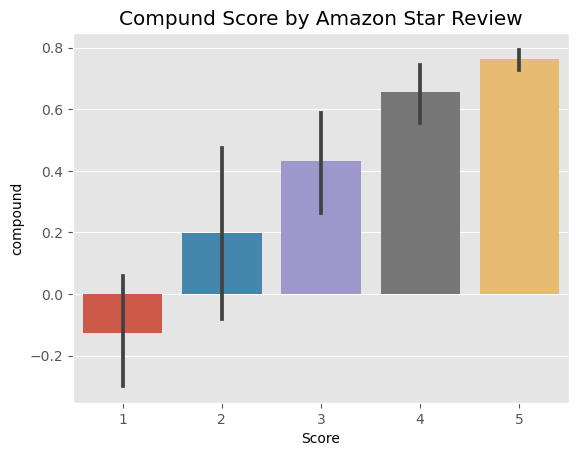

In [30]:
#Compound score and score plot
ax = sns.barplot(data=vaders, x='Score', y='compound')
ax.set_title('Compund Score by Amazon Star Review')
plt.show()


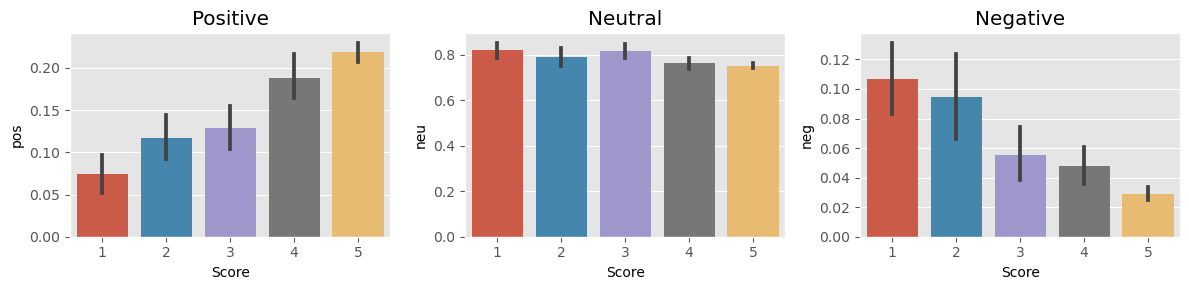

In [35]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

# Roberta base model test  <a class="anchor" id="section_4_1"></a>

In [174]:
#Set up the model
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
# MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

/home/tralala/anaconda3/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [175]:
# Run for Roberta Base Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.97635514, 'roberta_neu': 0.020687465, 'roberta_pos': 0.0029573692}


In [176]:
#Obtain neg neu and pos values 
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [177]:
#Prepare combined dict with Vader and Roberta scores 
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')


  0%|          | 0/500 [00:00<?, ?it/s]

Broke for id 83
Broke for id 187


In [178]:
#Prepare final df
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')

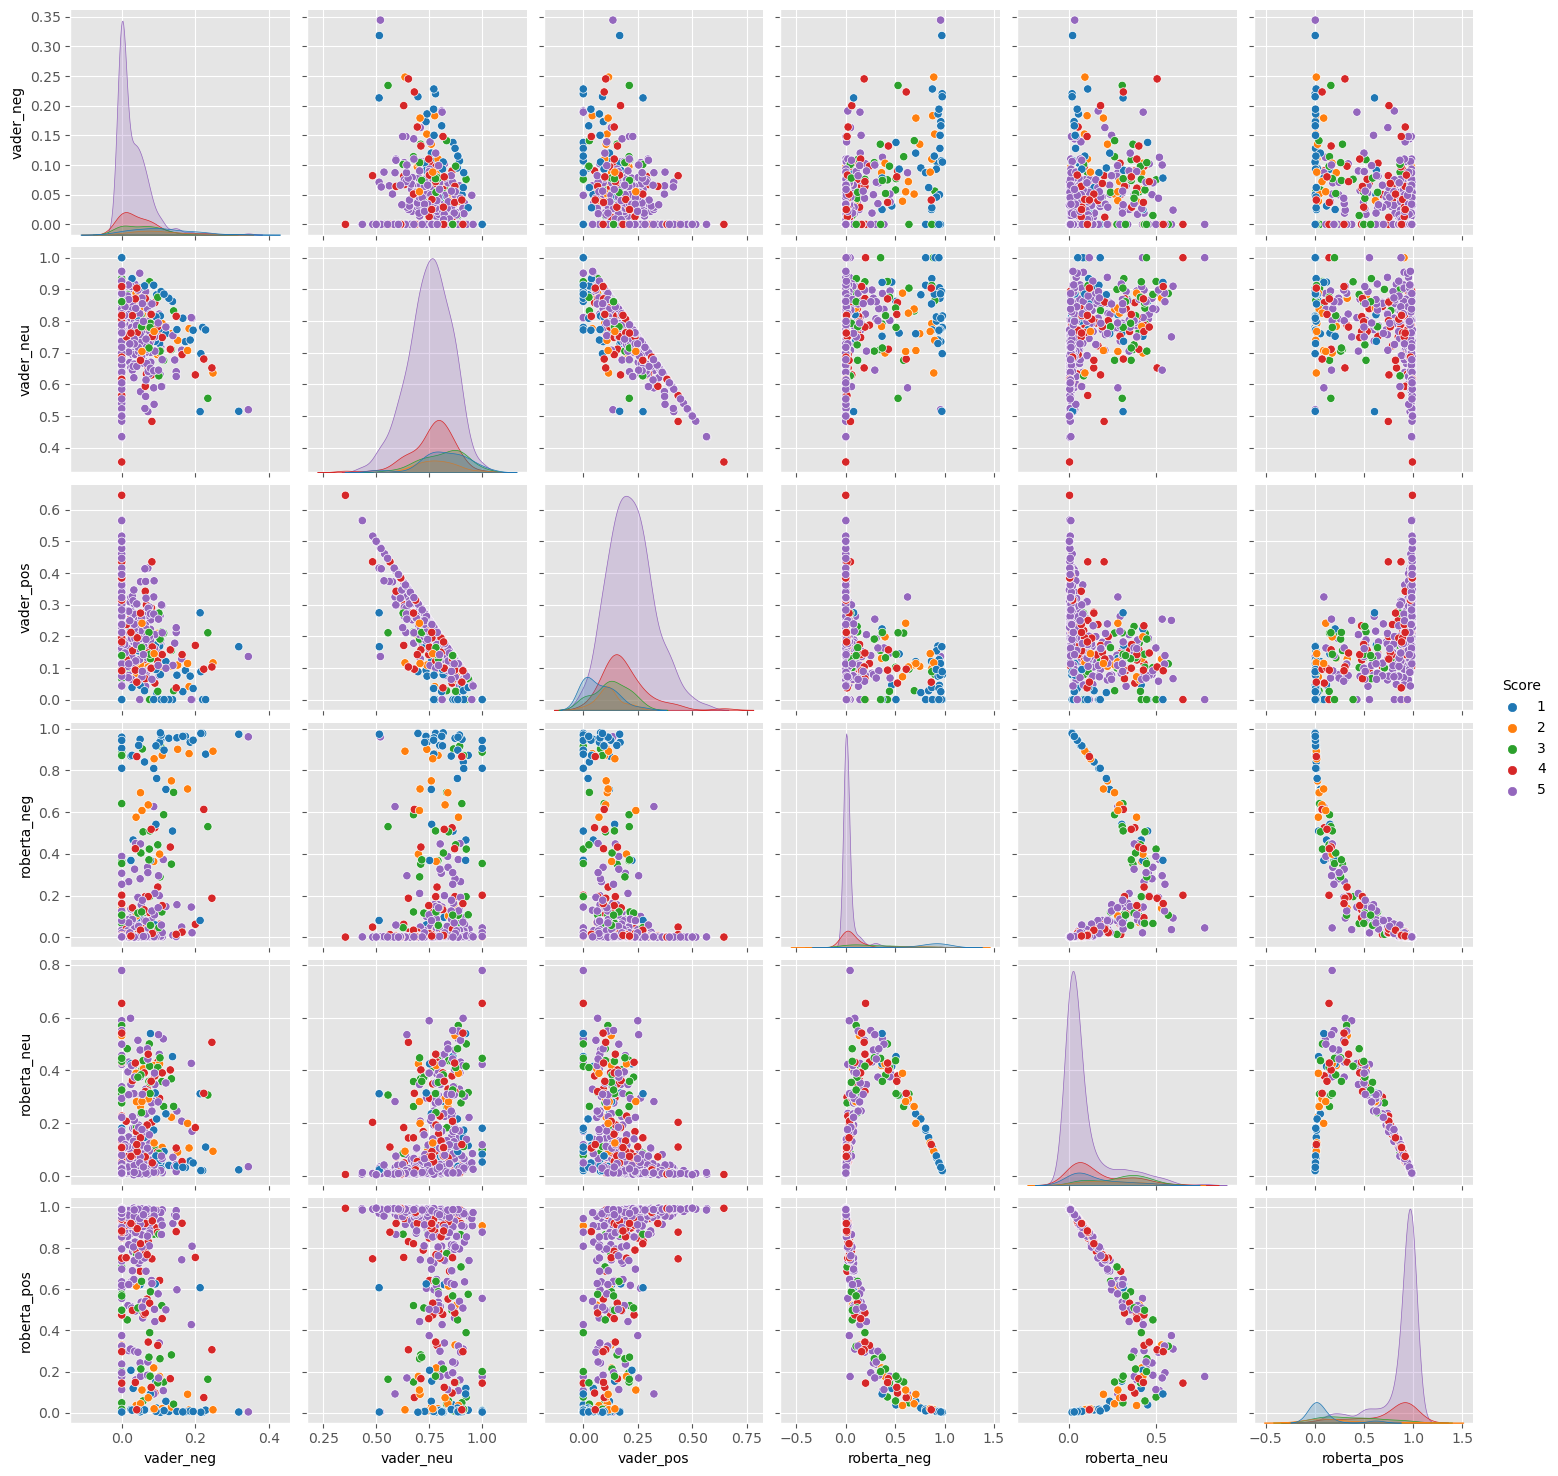

In [179]:
#Prepare pairplot
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='Score',
            palette='tab10')
plt.show()

## VADER vs RoBERTa Comparison <a class="anchor" id="section_5_1"></a>

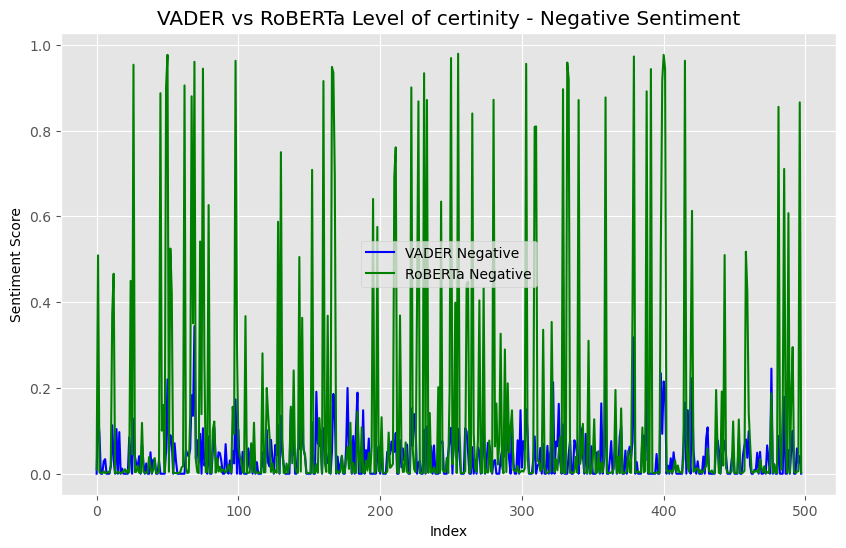

In [63]:
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(results_df['vader_neg'], label='VADER Negative', color='blue')
plt.plot(results_df['roberta_neg'], label='RoBERTa Negative', color='green')

# Adding titles and labels
plt.title('VADER vs RoBERTa Level of certinity - Negative Sentiment')
plt.xlabel('Index')
plt.ylabel('Sentiment Score')

# Show legend
plt.legend()

# Display the plot
plt.show()

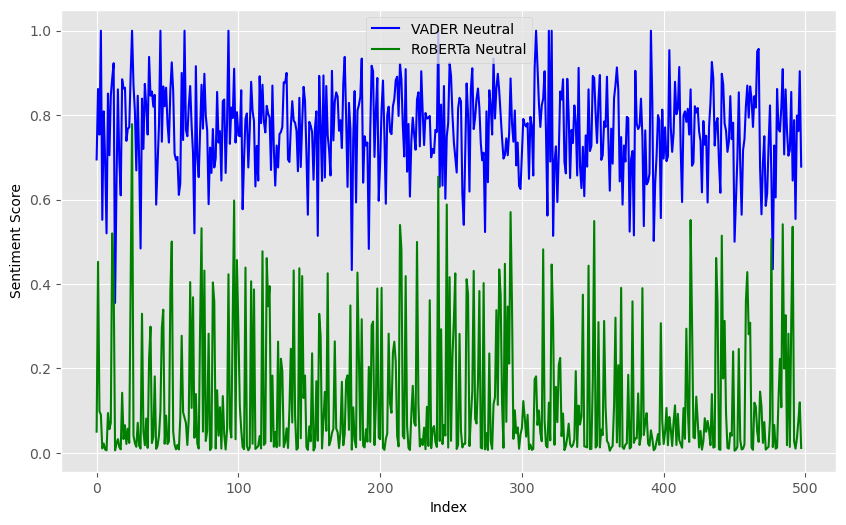

In [64]:
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(results_df['vader_neu'], label='VADER Neutral', color='blue')
plt.plot(results_df['roberta_neu'], label='RoBERTa Neutral', color='green')

# Adding titles and labelseutral Sentiment')
plt.xlabel('Index')
plt.ylabel('Sentiment Score')

# Show legend
plt.legend()

# Display the plot
plt.show()

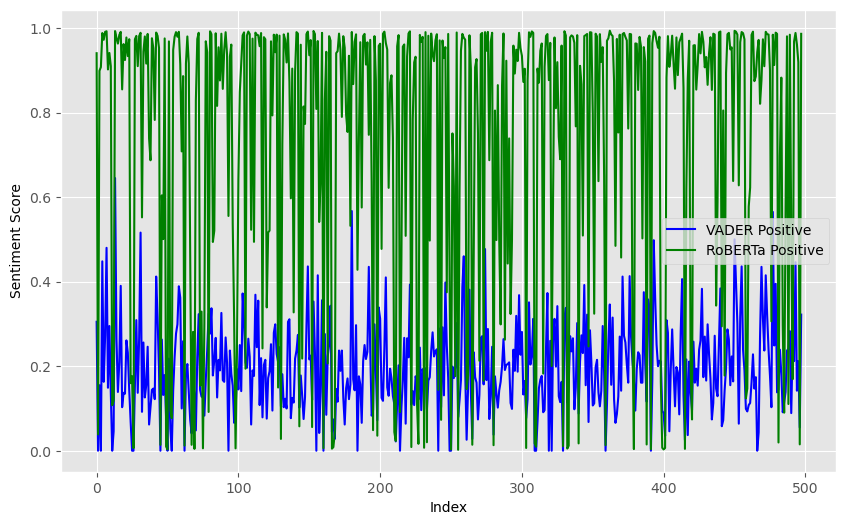

In [65]:
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(results_df['vader_pos'], label='VADER Positive', color='blue')
plt.plot(results_df['roberta_pos'], label='RoBERTa Positive', color='green')

# Adding titles and labelseutral Sentiment')
plt.xlabel('Index')
plt.ylabel('Sentiment Score')

# Show legend
plt.legend()

# Display the plot
plt.show()

# RoBERTa latest model test <a class="anchor" id="section_6_1"></a>

In [180]:
#Set up the model
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

/home/tralala/anaconda3/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassificat

In [181]:
# Run for Roberta Latest Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg_latest' : scores[0],
    'roberta_neu_latest' : scores[1],
    'roberta_pos_laters' : scores[2]
}
print(scores_dict)

{'roberta_neg_latest': 0.9535124, 'roberta_neu_latest': 0.040926374, 'roberta_pos_laters': 0.0055612465}


In [182]:
#Obtain neg neu and pos values 
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg_latest' : scores[0],
        'roberta_neu_latest' : scores[1],
        'roberta_pos_latest' : scores[2]
    }
    return scores_dict

In [183]:
#Prepare combined dict with Vader and Roberta scores 
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        roberta_result = polarity_scores_roberta(text)
        both = {**roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')


  0%|          | 0/500 [00:00<?, ?it/s]

Broke for id 83
Broke for id 187


In [184]:
#Update the final df
results_df_latest = pd.DataFrame(res).T
results_df_latest = results_df_latest.reset_index().rename(columns={'index': 'Id'})

In [187]:
df_latest_selected = results_df_latest[['roberta_neg_latest', 'roberta_neu_latest', 'roberta_pos_latest']]
df_selected = results_df[['roberta_neg', 'roberta_neu', 'roberta_pos']]

# Concatenate along the columns (axis=1) to combine the two dataframes side by side
combined_df = pd.concat([df_selected, df_latest_selected], axis=1)

# RoBERTa latest vs RoBERTa base <a class="anchor" id="section_7_1"></a>

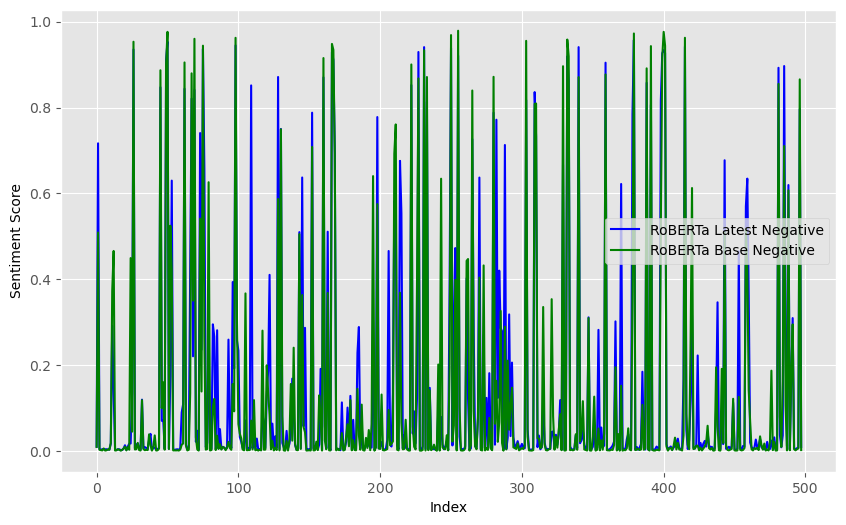

In [190]:
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(combined_df['roberta_neg_latest'], label='RoBERTa Latest Negative', color='blue')
plt.plot(combined_df['roberta_neg'], label='RoBERTa Base Negative', color='green')

# Adding titles and labelseutral Sentiment')
plt.xlabel('Index')
plt.ylabel('Sentiment Score')

# Show legend
plt.legend()

# Display the plot
plt.show()

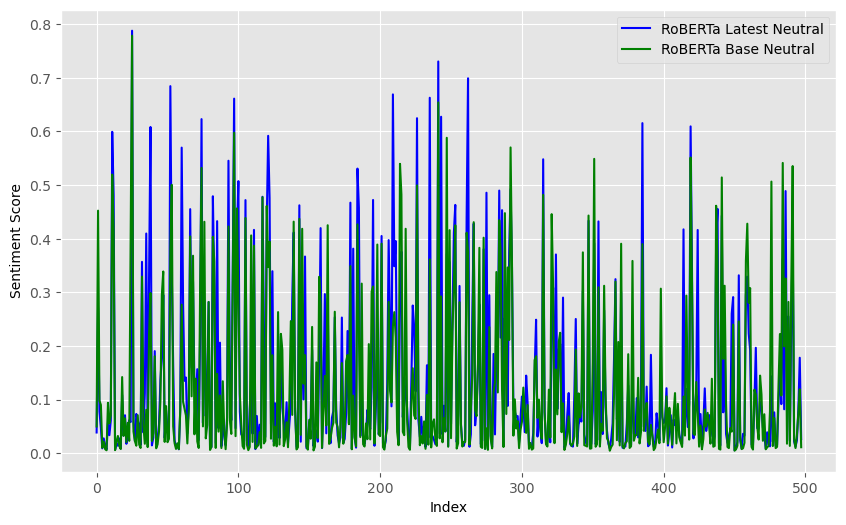

In [191]:
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(combined_df['roberta_neu_latest'], label='RoBERTa Latest Neutral', color='blue')
plt.plot(combined_df['roberta_neu'], label='RoBERTa Base Neutral', color='green')

# Adding titles and labelseutral Sentiment')
plt.xlabel('Index')
plt.ylabel('Sentiment Score')

# Show legend
plt.legend()

# Display the plot
plt.show()

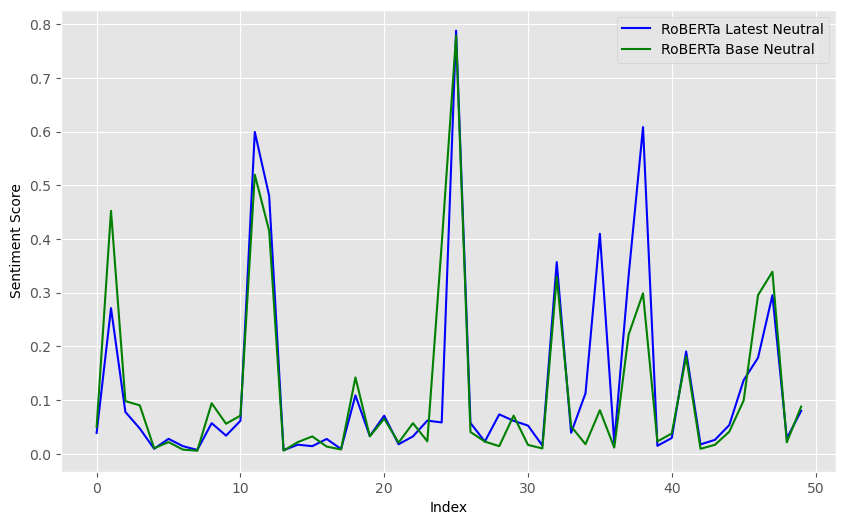

In [192]:
sample = combined_df.head(50)
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(sample['roberta_neu_latest'], label='RoBERTa Latest Neutral', color='blue')
plt.plot(sample['roberta_neu'], label='RoBERTa Base Neutral', color='green')

# Adding titles and labelseutral Sentiment')
plt.xlabel('Index')
plt.ylabel('Sentiment Score')

# Show legend
plt.legend()

# Display the plot
plt.show()

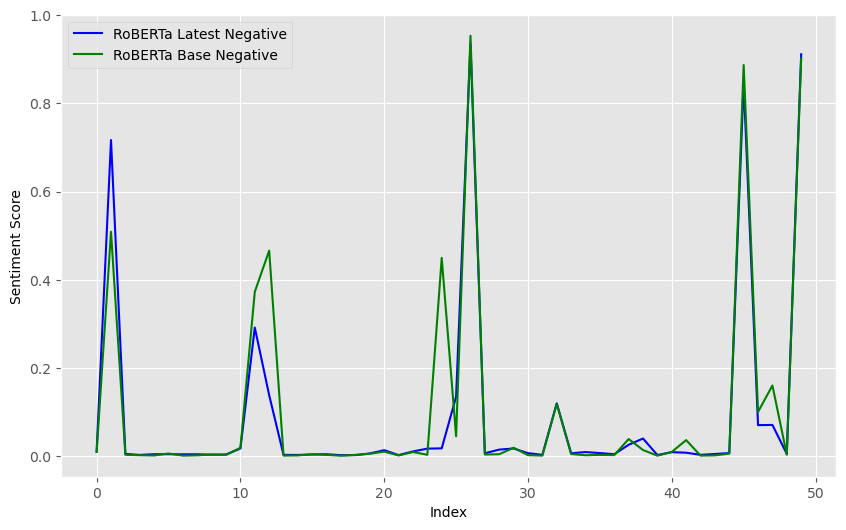

In [193]:
sample = combined_df.head(50)
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(sample['roberta_neg_latest'], label='RoBERTa Latest Negative', color='blue')
plt.plot(sample['roberta_neg'], label='RoBERTa Base Negative', color='green')

# Adding titles and labelseutral Sentiment')
plt.xlabel('Index')
plt.ylabel('Sentiment Score')

# Show legend
plt.legend()

# Display the plot
plt.show()

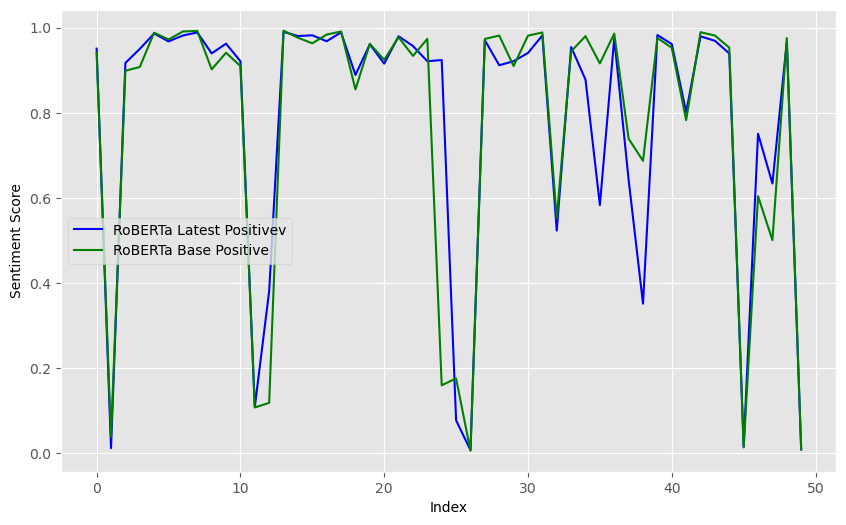

In [201]:
sample = combined_df.head(50)
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(sample['roberta_pos_latest'], label='RoBERTa Latest Positivev', color='blue')
plt.plot(sample['roberta_pos'], label='RoBERTa Base Positive', color='green')

# Adding titles and labelseutral Sentiment')
plt.xlabel('Index')
plt.ylabel('Sentiment Score')

# Show legend
plt.legend()

# Display the plot
plt.show()

In [203]:
df.iloc[38]['Text']

'I WAS VISITING MY FRIEND NATE THE OTHER MORNING FOR COFFEE , HE CAME OUT OF HIS STORAGE ROOM WITH ( A PACKET OF McCANNS INSTANT IRISH OATMEAL .) HE SUGGESTED THAT I TRY IT FOR MY OWN USE ,IN MY STASH . SOMETIMES NATE DOSE NOT GIVE YOU A CHANCE TO SAY NO , SO I ENDED UP TRYING THE APPLE AND CINN . FOUND IT TO BE VERY TASTEFULL WHEN MADE WITH WATER OR POWDERED MILK . IT GOES GOOD WITH O.J. AND COFFEE AND A SLICE OF TOAST AND YOUR READY TO TAKE ON THE WORLD...OR THE DAY AT LEAST..  JERRY REITH...'

In [202]:
sample.iloc[35:40]

,roberta_neg,roberta_neu,roberta_pos,roberta_neg_latest,roberta_neu_latest,roberta_pos_latest
35,0.003051,0.081101,0.915849,0.007127,0.409761,0.583113
36,0.002435,0.011576,0.985989,0.004470,0.020676,0.974855
37,0.038969,0.222001,0.739030,0.025911,0.331977,0.642112
38,0.014056,0.298830,0.687114,0.040124,0.608416,0.351460
39,0.001203,0.023011,0.975786,0.002639,0.014789,0.982572


Conclusion: RoBERTa latest has higher level of certinity and it is the best model for this task